In [156]:
import time
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import configparser
from get_genre_list import genre_list
import warnings
warnings.filterwarnings('ignore')

# get creds from the APP created from console
config = configparser.ConfigParser(interpolation=None)
config.read('config.ini')
cid = config.get('SPOTIFY', 'customer_id')
secret = config.get('SPOTIFY', 'secret_id')
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [158]:
def fetch_data(sp, year, genre):
    try:
        # create empty lists where the results are going to be stored
        artist_name = []
        track_name = []
        popularity = []
        track_id = []

        for i in range(0,1000,50):
            track_results = sp.search(q=f'year:{year} genre:{genre}', type='track', limit=50,offset=i)
            #print(i)
            for i, t in enumerate(track_results['tracks']['items']):
                artist_name.append(t['artists'][0]['name'])
                track_name.append(t['name'])
                track_id.append(t['id'])
                popularity.append(t['popularity'])

        df_tracks = pd.DataFrame({'artist_name':artist_name,'track_name':track_name,'track_id':track_id,'popularity':popularity, 'year':year, 'genre':genre})
        df_tracks.drop_duplicates(subset=['artist_name','track_name'], inplace=True)

        # empty list, batchsize and the counter for None results
        rows = []
        batchsize = 100
        None_counter = 0

        for i in range(0,len(df_tracks['track_id']),batchsize):
            batch = df_tracks['track_id'][i:i+batchsize]
            feature_results = sp.audio_features(batch)
            for i, t in enumerate(feature_results):
                if t == None:
                    None_counter = None_counter + 1
                else:
                    rows.append(t)

        #print('Number of tracks where no audio features were available:', None_counter)
        df_audio_features = pd.DataFrame.from_dict(rows,orient='columns')
        columns_to_drop = ['analysis_url','track_href','type']
        df_audio_features.drop(columns_to_drop, axis=1,inplace=True)
        df_audio_features.rename(columns={'id': 'track_id'}, inplace=True)

        df = pd.merge(df_tracks,df_audio_features,on='track_id',how='inner')
        #print("Shape of the dataset: ", df_audio_features.shape)
        df.drop_duplicates(subset=['artist_name','track_name'], inplace=True)
        return df

    except Exception:
        return pd.DataFrame()

In [159]:
start = time.time()
year_list = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
final_df = pd.DataFrame()
for year in year_list:
    for genre in genre_list:
        df = fetch_data(sp, year, genre)
        final_df = final_df.append(df, ignore_index=True)
    print(f"{year} completed | final_df length {len(final_df)}")
final_df.drop_duplicates(subset=['artist_name', 'track_name'], inplace=True)
print("Shape of the final dataset:", final_df.shape)

print(f'{(time.time() - start)/60} Minutes')

2000 completed | final_df length 735820
2001 completed | final_df length 795909
2002 completed | final_df length 857754
2003 completed | final_df length 921670
2004 completed | final_df length 985797
2005 completed | final_df length 1052090
2006 completed | final_df length 1119871
2007 completed | final_df length 1189836
2008 completed | final_df length 1260561
2009 completed | final_df length 1331504
2010 completed | final_df length 1401696
2011 completed | final_df length 1473396
Shape of the final dataset: (1159764, 19)
188.07595016558966 Minutes


<Axes: >

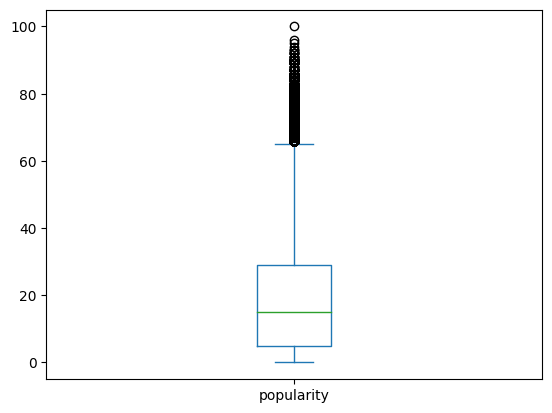

In [161]:
final_df['popularity'].plot(kind='box')

In [114]:
final_df.head()

,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Rainbow Kitten Surprise,It's Called: Freefall,474uVhyGgK5MtY9gMcDgGl,82,2018,rock,0.744,0.516,2,-6.365,1,0.0513,0.6320,0.000000,0.605,0.281,97.944,152293,4
1,The Neighbourhood,Softcore,2K7xn816oNHJZ0aVqdQsha,83,2018,rock,0.575,0.568,9,-5.509,0,0.0300,0.0484,0.000417,0.286,0.370,93.986,206280,4
2,The Neighbourhood,You Get Me So High,7zwn1eykZtZ5LODrf7c0tS,80,2018,rock,0.551,0.881,7,-6.099,0,0.0542,0.1860,0.079100,0.152,0.387,88.036,153000,4
3,MGMT,Little Dark Age,2Y0iGXY6m6immVb2ktbseM,79,2018,rock,0.705,0.712,6,-6.156,1,0.0385,0.0102,0.000855,0.100,0.620,97.512,299960,4
4,Panic! At The Disco,High Hopes,1rqqCSm0Qe4I9rUvWncaom,79,2018,rock,0.579,0.904,5,-2.729,1,0.0618,0.1930,0.000000,0.064,0.681,82.014,190947,4


In [163]:
final_df.isnull().sum()

artist_name         0
track_name          0
track_id            0
popularity          0
year                0
genre               0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64

In [ ]:
final_df.to_csv('../data/spotify_data_1M.csv')